# Applying prophet to time series forecasting of Well and Riser flow rates

## Author: Ridha Alkhabaz


## Imports:


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, dates
from prophet import Prophet
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import datetime as dttm
os.chdir('/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML/src')
from preprocessing import read_data_slugging, read_data_well
from configuration import configure 
os.chdir('/Users/ridhaalkhabaz/Documents/GitHub/VFM_ML')
from main import model_init, model_train, model_predict 

Importing plotly failed. Interactive plots will not work.


## Data configuration and readdings:


##### First the riser data needs some special reconfigurations:

## Deploying Prophet:
### The riser data set:

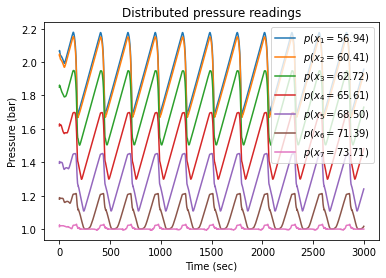

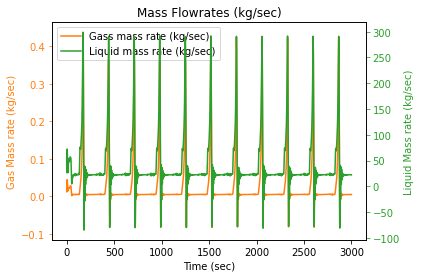

In [3]:
data_riser,headers, _= read_data_slugging('riser_pq_uni.csv', plot_data=True)
dft = pd.DataFrame.from_dict(dict(zip(['ds', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7','gas(kg/sec)', 'liquid(kg/sec)' ], data_riser.T)))
### univariate prophet 
train_uni = pd.concat([dft.iloc[:2806, 0], dft.iloc[:2806, 8:]], axis=1)
test_uni = pd.concat([dft.iloc[2806:, 0], dft.iloc[2806:len(dft), 8:]], axis=1)
### multivariate prophet 
train_mult = dft.iloc[:2806]
test_mult = dft.iloc[2806:len(dft)]

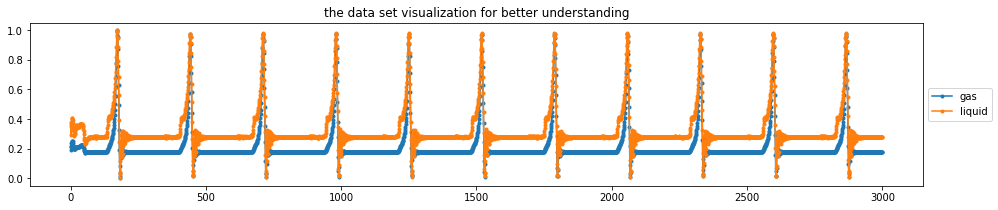

In [16]:
fig,ax = plt.subplots(figsize=(16,3))
ax.set_title('the data set visualization for better understanding')
ax.plot(dft['ds'], dft['gas(kg/sec)'], marker=".", label='gas')
ax.plot(dft['ds'], dft['liquid(kg/sec)'], marker=".", label='liquid')
ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [22]:
list_index_maximums = []
for i in range(0,2851, 150):
    print(i, i+150)
    a = list(dft.iloc[i:i+150,8])
    b = np.max(dft.iloc[i:i+150,8])
    print(np.max(dft.iloc[i:i+150,8]))
    print(dft[dft['gas(kg/sec)']==b].index.values)
    if b > 0.5:
        list_index_maximums.append(dft[dft['gas(kg/sec)']==b].index.values)

0 150
0.25419317643667516
[6]
150 300
1.0
[172]
300 450
0.9731194495787739
[442]
450 600
0.20572420969604244
[450]
600 750
0.9744441857481578
[711]
750 900
0.18065674012057362
[885]
900 1050
0.9734092950103824
[980]
1050 1200
0.18064081710014135
[1156]
1200 1350
0.9730795364373722
[1250]
1350 1500
0.26681333162277016
[1499]
1500 1650
0.9731242011432265
[1519]
1650 1800
0.9741096756106951
[1789]
1800 1950
0.20407557521647338
[1804]
1950 2100
0.974188551580608
[2058]
2100 2250
0.18043571846030307
[2248]
2250 2400
0.9715276754871541
[2327]
2400 2550
0.18069204160469837
[2503]
2550 2700
0.9739424205419633
[2597]
2700 2850
0.2951960099529437
[2849]
2850 3000
0.9743881172876171
[2866]


In [29]:
a = np.array(list_index_maximums).reshape(11)
for i in range(10):
    print(a[i+1]-a[i])

270
269
269
270
269
270
269
269
270
269


##### Applying:

In [5]:
prop_gas_riser = model_init(model='Prophet', params=['p1','p2','p3', 'p4', 'p5', 'p6', 'p7'], hyperparamters=[{'daily_seasonality':True,'holidays_prior_scale':10.0, 'seasonality_prior_scale':0.1,'changepoint_prior_scale':0.1, 'seasonality_mode':'additive'}])
prop_liq_riser = model_init(model='Prophet', params=['p1','p2','p3', 'p4', 'p5', 'p6', 'p7'], hyperparamters=[{'daily_seasonality':True,'holidays_prior_scale':10.0, 'seasonality_prior_scale':0.01,'changepoint_prior_scale':0.1, 'seasonality_mode':'multiplicative'}])

In [6]:
trained_prop_liq_riser = model_train(train_mult, 'liquid(kg/sec)', prop_liq_riser, 'Prophet',[], [])
trained_prop_gas_riser = model_train(train_mult, 'gas(kg/sec)', prop_gas_riser, 'Prophet',[], [])

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [7]:
prediction_data_gas, mse_gas = model_predict(test_mult, 'Prophet', trained_prop_gas_riser, 'gas(kg/sec)')
prediction_data_gas['ds'] = range(2805, 3000)
prediction_data_liquid, mse_liquid = model_predict(test_mult, 'Prophet', trained_prop_liq_riser, 'liquid(kg/sec)')
prediction_data_liquid['ds'] = range(2805, 3000)

#### Results:

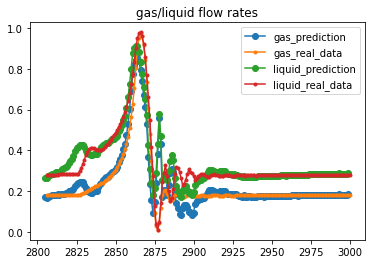

In [9]:
start_ploting = 0
end_ploting = len(test_mult)
## multivariate 
fig,ax = plt.subplots()
ax.set_title('gas/liquid flow rates')
ax.plot(prediction_data_gas['ds'].iloc[start_ploting:end_ploting], prediction_data_gas['yhat'].iloc[start_ploting:end_ploting], marker="o", label='gas_prediction')
ax.plot(test_mult['ds'].iloc[start_ploting:end_ploting], test_mult['gas(kg/sec)'].iloc[start_ploting:end_ploting], marker=".", label='gas_real_data')
ax.plot(prediction_data_liquid['ds'].iloc[start_ploting:end_ploting], prediction_data_liquid['yhat'].iloc[start_ploting:end_ploting], marker="o", label='liquid_prediction')
ax.plot(test_mult['ds'].iloc[start_ploting:end_ploting], test_mult['liquid(kg/sec)'].iloc[start_ploting:end_ploting], marker=".", label='liquid_real_data')
ax.legend(loc='upper right')
fig.savefig('riser-prophet-results.jpeg')

In [10]:
[mse_gas, mse_liquid]

[0.003975826426699838, 0.004752032882431754]

#### Finding the best parameters:

This block of code to show how we found the best parameters.

In [ ]:
import itertools
param_grid = {  
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_prior_scale':[0.01, 0.1, 1.0],
    'seasonality_mode': ['multiplicative', 'additive']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here



In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics
# Use cross validation to evaluate all parameters
gas_rmse = []
liq_rmse = []
number_iter = 0
# run this for three different 
for params in all_params:
    for i in range(0,2):
        trainSet_param = dft
        number_iter+=1
        if i == 0:
            trainSet_param = trainSet_param.rename(columns={'gas(kg/sec)':'y'})
            m_gas = Prophet(**params).fit(trainSet_param)  
            df_cv_gas = cross_validation(m_gas,horizon='900 nano', initial='2100 nano', parallel="processes")
            df_p_gas = performance_metrics(df_cv_gas, rolling_window=1)
            gas_rmse.append(df_p_gas['rmse'].values[0])
            print(number_iter)
        if i == 1:
            trainSet_param = trainSet_param.rename(columns={'liquid(kg/sec)':'y'})
            m_liq = Prophet(**params).fit(trainSet_param) 
            df_cv_liq = cross_validation(m_liq,horizon='900 nano', initial='2100 nano', parallel="processes")
            df_p_liq = performance_metrics(df_cv_liq, rolling_window=1)
            liq_rmse.append(df_p_liq['rmse'].values[0])
            print(number_iter)

### The Well dataset:


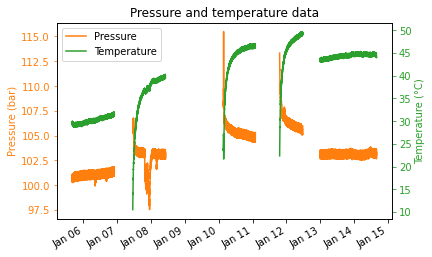

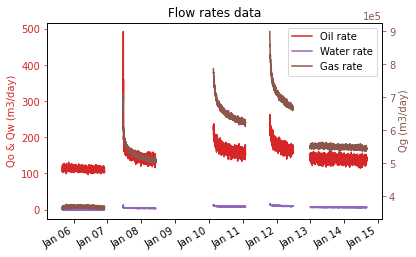

In [11]:
fp, headers, scaler = read_data_well('welltest.csv', plot_data=True)

##### Whole day training:

In [12]:
# three to one ratio for training and testing 
df_epochs = np.array(range(5))
df = pd.DataFrame.from_dict(dict(zip(headers, fp[df_epochs[0]].T)))
for i in df_epochs[1:]:
    tmp = pd.DataFrame.from_dict(dict(zip(headers, fp[i].T)))
    df = pd.concat([df,tmp], axis=0)
df = df.rename(columns={'DateTime':'ds'})

In [13]:
train_mult = df.iloc[int(0.5*len(fp[0])):int(0.5*len(fp[3]))+len(fp[1])+len(fp[0])+len(fp[2])]
train_uni = pd.concat([train_mult['ds'], train_mult.iloc[:, 3:]], axis=1)
test_mult= df.iloc[int(0.5*len(fp[3]))+len(fp[1])+len(fp[0])+len(fp[2]):len(fp[1])+len(fp[0])+len(fp[2])+len(fp[3])]
test_uni = pd.concat([test_mult['ds'], test_mult.iloc[:, 3:]], axis=1)

#### Shut-in moments:

In [14]:
shut_in_after = ['2016-01-07 10:59:00', '2016-01-10 03:12:00', '2016-01-11 19:12:00', '2016-01-13 00:00:00']
shut_in_before =['2016-01-06 21:56:00', '2016-01-08 10:12:00', '2016-01-11 01:57:00','2016-01-12 11:29:00']

In [15]:
shut_in = pd.DataFrame({
    'holiday': 'shut-in',
    'ds': pd.to_datetime(['2016-01-07 10:59:00', '2016-01-10 03:12:00', '2016-01-11 19:12:00', '2016-01-13 00:00:00', '2016-01-06 21:56:00', '2016-01-08 10:12:00', '2016-01-11 01:57:00','2016-01-12 11:29:00']),
    'lower_window' :0,
    'upper_window' :10
})
#fill the gap with artificial data with constant 

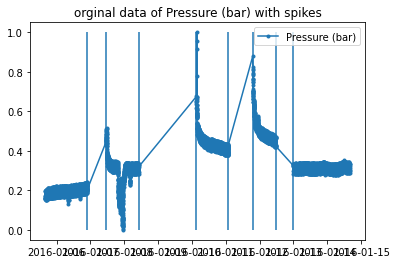

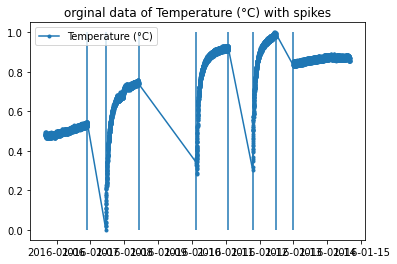

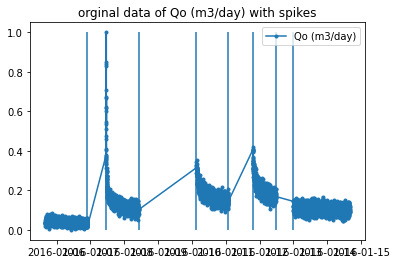

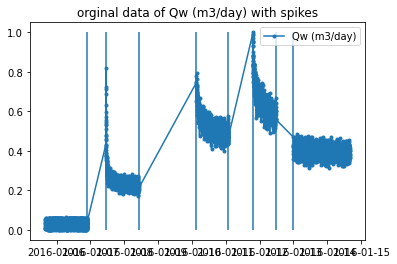

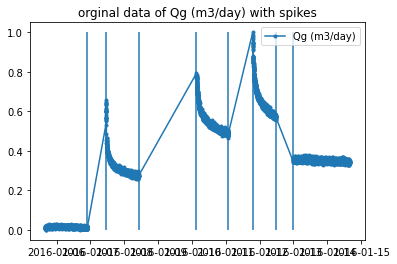

In [16]:
start  = 0
end = len(df)
shutIn = [len(fp[0]), len(fp[1]), len(fp[2]), len(fp[3])]
for i in headers[1:]:
    fig,ax = plt.subplots()
    ax.set_title('orginal data of %s with spikes'%i)
    ax.plot(df['ds'].iloc[start:end], df[i].iloc[start:end], marker=".", label='%s'%i)
    ax.vlines(shut_in_after+shut_in_before, 0, 1)
    ax.legend()

##### part of day training:

In [ ]:
df = pd.DataFrame.from_dict(dict(zip(headers, fp[0].T)))
df = df.rename(columns={'DateTime':'ds'})
train = df.iloc[:int(0.7*len(df))]
test = df.iloc[int(0.7*len(df)):len(df)]

##### Applying:


In [7]:
### Old paramters { daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, holidays_prior_scale=10.0, seasonality_mode='multiplicative'}
def model_well_fit(train, test, y='Qo (m3/day)', mult=False, gas_change=0.5):
    trainSet = train.rename(columns={y:'y'})
    testSet = test.rename(columns={y:'y'})
    if mult:
        if y == 'Qo (m3/day)':
            ## oil flow rate fitting (multi)
            model_oil_mult = Prophet(daily_seasonality=False,weekly_seasonality=False, yearly_seasonality=True, \
                                     changepoint_prior_scale=0.001, seasonality_prior_scale=0.01, \
                                     holidays_prior_scale=0.01, seasonality_mode='multiplicative')
            model_oil_mult.add_regressor('Pressure (bar)')
            model_oil_mult.add_regressor('Temperature (°C)')
            model_oil_mult.fit(trainSet)
            oil_test_mult = model_oil_mult.predict(testSet.drop(columns="y"))
            oil_train_mult = model_oil_mult.predict(trainSet.drop(columns="y"))
            return model_oil_mult, oil_test_mult, oil_train_mult
        if y == 'Qw (m3/day)':
            ## water flow rate fitting (multi)
            model_water_mult = Prophet(daily_seasonality=False,weekly_seasonality=False, yearly_seasonality=False,\
                                       changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, \
                                       holidays_prior_scale=1.0, seasonality_mode='additive')
            model_water_mult.add_regressor('Pressure (bar)')
            model_water_mult.add_regressor('Temperature (°C)')
            model_water_mult.add_seasonality(name='hourly', period=110, fourier_order=3)
            model_water_mult.fit(trainSet)
            water_test_mult = model_water_mult.predict(testSet.drop(columns="y"))
            water_train_mult = model_water_mult.predict(trainSet.drop(columns="y"))
            return model_water_mult,water_test_mult, water_train_mult
        ## gas flow rate fitting (multi)
        model_gas_mult = Prophet(daily_seasonality=False,weekly_seasonality=False, yearly_seasonality=False,\
                                 changepoint_prior_scale=12.0, seasonality_prior_scale=0.1, \
                                 holidays_prior_scale=0.01, seasonality_mode='multiplicative')
        model_gas_mult.add_regressor('Pressure (bar)')
        model_gas_mult.add_regressor('Temperature (°C)')
        model_gas_mult.fit(trainSet)
        gas_test_mult = model_gas_mult.predict(testSet.drop(columns="y"))
        gas_train_mult = model_gas_mult.predict(trainSet.drop(columns="y"))
        return model_gas_mult, gas_test_mult, gas_train_mult
    if y == 'Qo (m3/day)':
            ## oil flow rate fitting (uni)
            model_oil_uni = Prophet(holidays=shut_in)
            model_oil_uni.fit(trainSet)
            oil_test_uni = model_oil_uni.predict(testSet.drop(columns="y"))
            oil_train_uni = model_oil_uni.predict(trainSet.drop(columns="y"))
            return model_oil_uni, oil_test_uni, oil_train_uni
    if y == 'Qw (m3/day)':
        ## water flow rate fitting (uni)
        model_water_uni = Prophet(holidays=shut_in)
        model_water_uni.fit(trainSet)
        water_test_uni = model_water_uni.predict(testSet.drop(columns="y"))
        water_train_uni = model_water_uni.predict(trainSet.drop(columns="y"))
        return model_water_uni,water_test_uni, water_train_uni

    ## gas flow rate fitting (uni)
    model_gas_uni = Prophet(holidays=shut_in)
    model_gas_uni.fit(trainSet)
    gas_test_uni = model_gas_uni.predict(testSet.drop(columns="y"))
    gas_train_uni = model_gas_uni.predict(trainSet.drop(columns="y"))
    return model_gas_uni, gas_test_uni, gas_train_uni

In [8]:
## gas 
# gas_model_mult, gas_ts_mult, gas_tr_mult = model_well_fit(train_mult, test_mult, y='Qg (m3/day)', mult=True)
# ## oil 
# oil_model_mult, oil_ts_mult, oil_tr_mult = model_well_fit(train_mult, test_mult, y='Qo (m3/day)', mult=True)
# # # ## water 
# water_model_mult, water_ts_mult, water_tr_mult = model_well_fit(train_mult, test_mult, y='Qw (m3/day)', mult=True)


INFO:numexpr.utils:NumExpr defaulting to 4 threads.


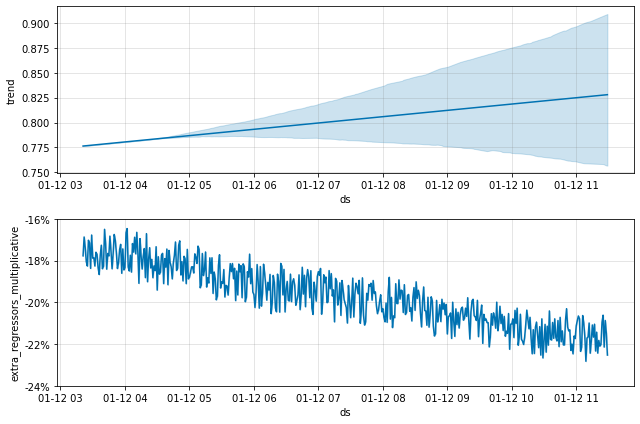

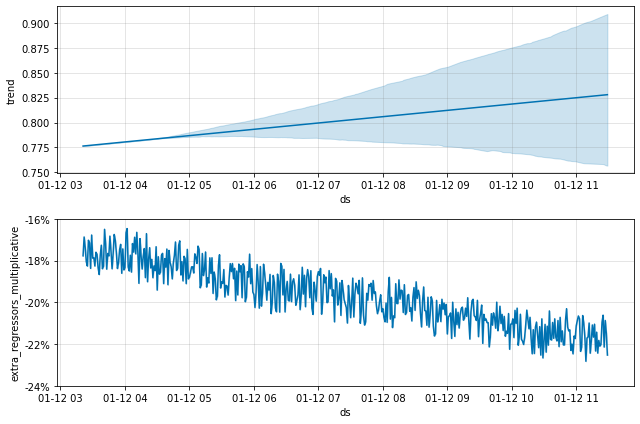

In [9]:
gas_model_mult.plot_components(gas_ts_mult)

In [10]:
model_gas_well = model_init(model='Prophet', params=['Pressure (bar)', 'Temperature (°C)'], hyperparamters={'daily_seasonality':False,'weekly_seasonality':False, 'yearly_seasonality':False,'changepoint_prior_scale':12.0, 'seasonality_prior_scale':0.1, \
                        'holidays_prior_scale':0.01, 'seasonality_mode':'multiplicative'})

In [11]:
model_gas_well_trained = model_train(train_mult, 'Qg (m3/day)', model_gas_well, 'Prophet', [], [])

In [12]:
prediction_gas_well, mse_gas_well =  model_predict(test_mult, 'Prophet', model_gas_well_trained, 'Qg (m3/day)')

##### Results

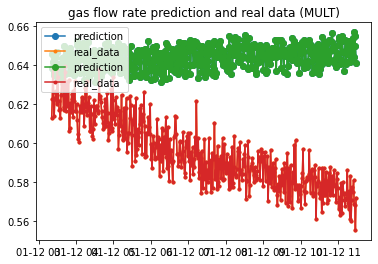

In [13]:
start_ploting = 0
end_ploting = len(test_mult)
## multivariate 
fig,ax = plt.subplots()
ax.set_title('gas flow rate prediction and real data (MULT)')
ax.plot(gas_ts_mult['ds'].iloc[start_ploting:end_ploting], gas_ts_mult['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(test_mult['ds'].iloc[start_ploting:end_ploting], test_mult['Qg (m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
ax.plot(prediction_gas_well['ds'].iloc[start_ploting:end_ploting], prediction_gas_well['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(test_mult['ds'].iloc[start_ploting:end_ploting], test_mult['Qg (m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
ax.legend(loc='upper left')


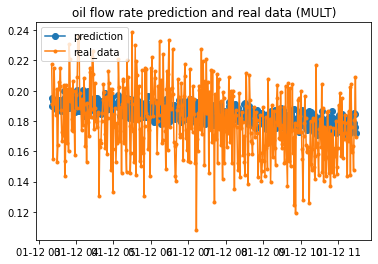

In [165]:
start_ploting = 0
end_ploting = len(oil_tr_mult)
## multivariate 
fig,ax = plt.subplots()
ax.set_title('oil flow rate prediction and real data (MULT)')
ax.plot(oil_ts_mult['ds'].iloc[start_ploting:end_ploting], oil_ts_mult['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(test_mult['ds'].iloc[start_ploting:end_ploting], test_mult['Qo (m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
#ax.plot(train_mult['ds'].iloc[start_ploting:end_ploting], train_mult['Qo (m3/day)'].iloc[start_ploting:end_ploting], marker="o", label='real')
#ax.plot(oil_tr_mult['ds'].iloc[start_ploting:end_ploting], oil_tr_mult['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.legend(loc='upper left')


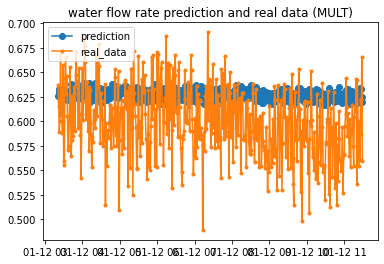

In [166]:
start_ploting = 0
end_ploting = len(test_mult)
## multivariate 
fig,ax = plt.subplots()
ax.set_title('water flow rate prediction and real data (MULT)')
ax.plot(water_ts_mult['ds'].iloc[start_ploting:end_ploting], water_ts_mult['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(test_mult['ds'].iloc[start_ploting:end_ploting], test_mult['Qw (m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
# ax.plot(train_mult['ds'].iloc[start_ploting:end_ploting], train_mult['Qw (m3/day)'].iloc[start_ploting:end_ploting], marker="o", label='real')
# ax.plot(water_tr_mult['ds'].iloc[start_ploting:end_ploting], water_tr_mult['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.legend(loc='upper left')


## Finding the best parameters
THis is meant to be run once to find the best hyperparameters.

In [193]:
import itertools
param_grid = {  
    'seasonality_prior_scale': [0.01, 0.1],
    'holidays_prior_scale': [0.01, 1.0],
    'seasonality_mode': ['multiplicative', 'additive'],
    'daily_seasonality': [True, False], 
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False], 
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here


In [196]:
[**all_params[0]]

SyntaxError: invalid syntax (<ipython-input-196-32f655793a9f>, line 1)

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics
# Use cross validation to evaluate all parameters
gas_rmse = []
water_rmse = []
oil_rmse = []
number_iter = 0
# run this for three different 
for params in all_params:
    for i in range(0,3):
        trainSet_param = df
        number_iter+=1
        if i == 0:
            trainSet_param = trainSet_param.rename(columns={'Qo (m3/day)':'y'})
            m_oil = Prophet(**params).add_regressor('Pressure (bar)')\
                        .add_regressor('Temperature (°C)').fit(trainSet_param)  
            df_cv_oil = cross_validation(m_oil,horizon='1 days', initial='3 days', parallel="processes")
            df_p_oil = performance_metrics(df_cv_oil, rolling_window=1)
            oil_rmse.append(df_p_oil['rmse'].values[0])
            print(number_iter)
        if i == 1:
            trainSet_param = trainSet_param.rename(columns={'Qg (m3/day)':'y'})
            m_gas = Prophet(**params).add_regressor('Pressure (bar)')\
                        .add_regressor('Temperature (°C)').fit(trainSet_param)  
            df_cv_gas = cross_validation(m_gas,horizon='1 days', initial='3 days', parallel="processes")
            df_p_gas = performance_metrics(df_cv_gas, rolling_window=1)
            gas_rmse.append(df_p_gas['rmse'].values[0])
            print(number_iter)
        if i == 2:
            trainSet_param = trainSet_param.rename(columns={'Qw (m3/day)':'y'})
            m_water = Prophet(**params).add_regressor('Pressure (bar)')\
                        .add_regressor('Temperature (°C)').fit(trainSet_param)  
            df_cv_water = cross_validation(m_water,horizon='1 days', initial='3 days', parallel="processes")
            df_p_water = performance_metrics(df_cv_water, rolling_window=1)
            water_rmse.append(df_p_water['rmse'].values[0])
            print(number_iter)

In [ ]:
tuning_results = pd.DataFrame(all_params)
tuning_results['oil'] = oil_rmse
tuning_results['water'] = water_rmse
tuning_results['gas'] = gas_rmse

In [ ]:
tuning_results.head()

In [ ]:
tuning_results = pd.read_csv('tuning.csv')

In [ ]:
tuning_results[tuning_results['oil'] == tuning_results['oil'].min()]

In [ ]:
tuning_results[tuning_results['water'] == tuning_results['water'].min()]

In [ ]:
tuning_results[tuning_results['gas'] == tuning_results['gas'].min()]

#### Apendix:
The model fit for slugging and other functions

In [ ]:
def model_riser_fit(train, test, y='gas(kg/sec)', mult=False):
    train = train.rename(columns={y:'y'})
    test = test.rename(columns={y:'y'})
    if mult:
        if y == 'gas(kg/sec)':
            prop_mult = Prophet(daily_seasonality=True,holidays_prior_scale=10.0,\
                                seasonality_prior_scale=0.1,changepoint_prior_scale=0.1, seasonality_mode='additive')
            prop_mult.add_regressor('p1')
            prop_mult.add_regressor('p2')
            prop_mult.add_regressor('p3')
            prop_mult.add_regressor('p4')
            prop_mult.add_regressor('p5')
            prop_mult.add_regressor('p6')
            prop_mult.add_regressor('p7')
            prop_mult.fit(train)
            forecast = prop_mult.predict(test.drop(columns="y"))
            return prop_mult, forecast
        # liquid prediction
        m_mult = Prophet(daily_seasonality=True,seasonality_prior_scale=0.01, holidays_prior_scale=10.0, changepoint_prior_scale=0.1, seasonality_mode='multiplicative')
        m_mult.add_regressor('p1')
        m_mult.add_regressor('p2')
        m_mult.add_regressor('p3')
        m_mult.add_regressor('p4')
        m_mult.add_regressor('p5')
        m_mult.add_regressor('p6')
        m_mult.add_regressor('p7')
        m_mult.fit(train)
        forecast = m_mult.predict(test.drop(columns="y"))
        return m_mult, forecast
    if y == 'gas(m3/day)':
            prop_uni = Prophet(daily_seasonality=True,holidays_prior_scale=10.0,\
                                seasonality_prior_scale=0.1,changepoint_prior_scale=0.1, seasonality_mode='additive')
            prop_uni.fit(train)
            forecast = prop_uni.predict(test.drop(columns="y"))
            return prop_uni, forecast
    ## liquid univariate 
    m_uni = Prophet(daily_seasonality=True,seasonality_prior_scale=0.01, holidays_prior_scale=10.0, changepoint_prior_scale=0.1, seasonality_mode='multiplicative')
    m_uni.fit(train)
    forecast = m_uni.predict(test.drop(columns="y"))
    return m_uni, forecast